In [201]:
%matplotlib inline 
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 

import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2

import librosa
import librosa.display
import skimage.io

from sklearn.preprocessing import LabelEncoder

**Preprocessing**

In [46]:
ravdess_emotions = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad',\
                   '05':'angry', '06':'fear', '07':'disgust','08':'surprise'}

In [139]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

def get_image_path(file_path):
    path_list = file_path.split('/')
    img_path = path_list[-1]
    
     # settings
    hop_length = 512 # number of samples per time-step in spectrogram
    n_mels = 128 # number of bins in spectrogram. Height of image
    time_steps = 384 # number of time-steps. Width of image

    # load audio. Using example from librosa
    y, sr = librosa.load(file_path, offset=1.0, duration=10.0, sr=22050)
    out = 'data/images/' + img_path[:-4] + '.png'

    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]
    
    # convert to PNG
    spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    # print('wrote file', out)
    
    return out

In [239]:
processed_data = []
# Folder path of the data 
data_path = 'data/speech-emotion-recognition-ravdess-data/'

# Extracting Label of audio clip from the file name based on the name of the dataset. 
for root, dirs, files in os.walk(data_path):
    for file in files:
        if not file.endswith('.DS_Store'):
            file_path = os.path.join(root, file)
            # Split the file name based on dataset
            file_breakdown = file.split('-')
            if file_breakdown[3] == '01' and file_breakdown[5] == '01':
                emotion = ravdess_emotions[file_breakdown[2]]
                emotion_id = int(file_breakdown[2])
                statement = int(file_breakdown[4])
                actor = int(file_breakdown[6][:-4])
            
                img_path = get_image_path(file_path)
                #print(emotion)
                processed_data.append([file_path, actor, emotion, emotion_id, statement, img_path])
print("All Images Written")
# Compute Recipe Outputs: 
speech_data_processed_df = pd.DataFrame(processed_data, columns=['file_name','actor','emotions','emotion_id','statement','image_path'])

All Images Written


In [240]:
speech_data_processed_df.head()

,file_name,actor,emotions,emotion_id,statement,image_path
0,data/speech-emotion-recognition-ravdess-data/A...,16,angry,5,2,data/images/03-01-05-01-02-01-16.png
1,data/speech-emotion-recognition-ravdess-data/A...,16,disgust,7,1,data/images/03-01-07-01-01-01-16.png
2,data/speech-emotion-recognition-ravdess-data/A...,16,surprise,8,1,data/images/03-01-08-01-01-01-16.png
3,data/speech-emotion-recognition-ravdess-data/A...,16,calm,2,2,data/images/03-01-02-01-02-01-16.png
4,data/speech-emotion-recognition-ravdess-data/A...,16,happy,3,2,data/images/03-01-03-01-02-01-16.png


In [241]:
# Audio File: 
print(f"Audio: {speech_data_processed_df.file_name[0]}")
# Image File: 
print(f"Image: {speech_data_processed_df.image_path[0]}")

Audio: data/speech-emotion-recognition-ravdess-data/Actor_16/03-01-05-01-02-01-16.wav
Image: data/images/03-01-05-01-02-01-16.png


**Understanding Class Imbalance**

In [242]:
speech_data_processed_df.groupby('emotions').count()

,file_name,actor,emotion_id,statement,image_path
emotions,,,,,
angry,48,48,48,48,48
calm,48,48,48,48,48
disgust,48,48,48,48,48
fear,48,48,48,48,48
happy,48,48,48,48,48
neutral,48,48,48,48,48
sad,48,48,48,48,48
surprise,48,48,48,48,48


**Understanding Acoustic Feature Extraction**

In [149]:
import wave

In [150]:
sf_filewave = wave.open('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav')
signal_sf = sf_filewave.readframes(-1)

# Convert audio bytes to integers
soundwave_sf = np.frombuffer(signal_sf, dtype='int16')

# Get the sound wave frame rate 
framerate_sf = sf_filewave.getframerate()

# Find the sound wave timestamps 
time_sf = np.linspace(start=0, stop=len(soundwave_sf)/framerate_sf, num=len(soundwave_sf))

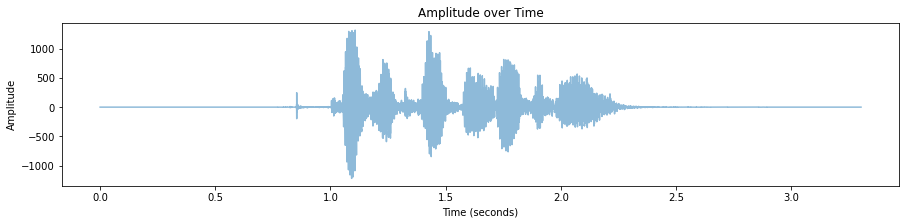

In [158]:
fig, ax = plt.subplots(figsize=(15,3))

# Setup the title and axis titles
plt.title('Amplitude over Time')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
# Add the audio data to the plot
ax.plot(time_sf, soundwave_sf, alpha=0.5)
plt.show()

In [68]:
x, sr = librosa.load('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-02-01.wav', offset=1.0, duration=10.0, sr=22050)

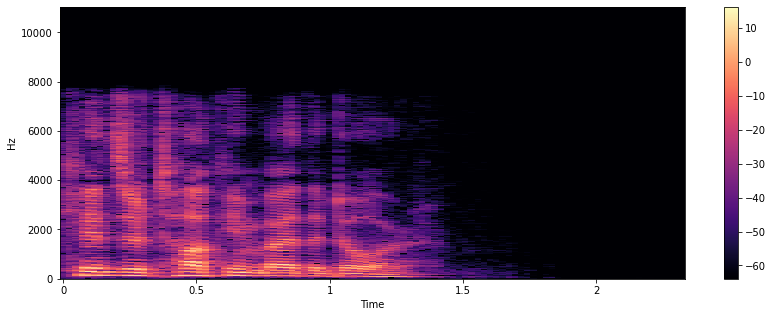

In [69]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

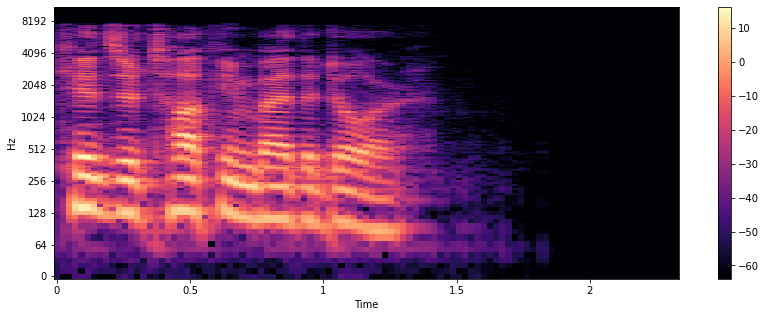

In [70]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

**Sorting Dataframe**

In [243]:
speech_data_processed_df = speech_data_processed_df.sort_values(by=['actor','statement','emotion_id'], ignore_index=True)

In [246]:
speech_data_processed_df.head(16)

,file_name,actor,emotions,emotion_id,statement,image_path
0,data/speech-emotion-recognition-ravdess-data/A...,1,neutral,1,1,data/images/03-01-01-01-01-01-01.png
1,data/speech-emotion-recognition-ravdess-data/A...,1,calm,2,1,data/images/03-01-02-01-01-01-01.png
2,data/speech-emotion-recognition-ravdess-data/A...,1,happy,3,1,data/images/03-01-03-01-01-01-01.png
3,data/speech-emotion-recognition-ravdess-data/A...,1,sad,4,1,data/images/03-01-04-01-01-01-01.png
4,data/speech-emotion-recognition-ravdess-data/A...,1,angry,5,1,data/images/03-01-05-01-01-01-01.png
5,data/speech-emotion-recognition-ravdess-data/A...,1,fear,6,1,data/images/03-01-06-01-01-01-01.png
6,data/speech-emotion-recognition-ravdess-data/A...,1,disgust,7,1,data/images/03-01-07-01-01-01-01.png
7,data/speech-emotion-recognition-ravdess-data/A...,1,surprise,8,1,data/images/03-01-08-01-01-01-01.png
8,data/speech-emotion-recognition-ravdess-data/A...,1,neutral,1,2,data/images/03-01-01-01-02-01-01.png
9,data/speech-emotion-recognition-ravdess-data/A...,1,calm,2,2,data/images/03-01-02-01-02-01-01.png


**Notes:**
for the dataset and dataloader

We want it to return:
> x, y \
(1 image - Emotion , All 8 images - Emotions)

> Image: Tensor X: [batch_size,1,H,W] Y: [batch_size, 8, H, W]

Model: \
GAN: 1 image to all other images
Loss: 6 Predicted vs 6 Actual [for that actor] 

1 Emotion translate to all other emotions 

**Dataset**

In [268]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.imgs_files = [f for f in df.image_path.values]
        self.label = [f for f in df['emotion_id'].values]
    
    def __len__(self): 
        return len(self.label)
    
    def _getname__(self, idx): 
        return self.label[idx]
    
    def __getitem__(self, idx):
        
        img_paths = self.imgs_files[idx:idx+8]
        label = self.label[idx]
        
        imgs = []
        # Read Image:
        for img_path in img_paths: 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
                
        images = torch.from_numpy(np.array(imgs))
                    
        return images[0].unsqueeze(0), images[1:]

In [269]:
train_ds = EmotionDataset(speech_data_processed_df)

In [270]:
x,y = train_ds.__getitem__(0)

In [271]:
x.size(), y.size()

(torch.Size([1, 128, 128]), torch.Size([7, 128, 128]))